In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention,concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from hydroeval import evaluator, nse

C:\Users\57\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\57\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issu

In [2]:

data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
data.set_index('Ngay', inplace=True)
print(data.head(5))

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
01/01/2008        120        498.815         259.499               0.0   
02/01/2008        117        470.866         518.755               0.0   
03/01/2008        139        423.816         615.242               0.0   
04/01/2008        166        496.882         902.982               0.0   
05/01/2008        179        501.232        1072.970               0.0   

            chayMayTuyenQuan  nuocVeThacBa  chayMayThacBa  
Ngay                                                       
01/01/2008               0.0        23.230         90.200  
02/01/2008               0.0        26.239        213.791  
03/01/2008               0.0        24.000        175.000  
04/01/2008               0.0        11.000        164.000  
05/01/2008               0.0        24.000        177.000  


In [3]:
# Chuẩn hóa dữ liệu để đưa về khoảng [0, 1] để dễ xử lý khi đưa vào mô hình
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [4]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])  
    return np.array(sequences), np.array(targets)

In [5]:
sequence_length = 10 # Sử dụng số ngày trước để dự báo ngày tiếp theo
X, y = create_sequences(data_scaled, sequence_length)
print(X.shape[2])

7


In [18]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(X_train.shape[2])

7


In [7]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Dự đoán mực nước (1 giá trị)
])

In [8]:
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            18432     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30881 (120.63 KB)
Trainable params: 30881 (120.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# 3. Huấn luyện mô hình
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Dừng nếu không cải thiện sau 10 epochs
    restore_best_weights=True
)
history = model.fit(X_train,y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping],verbose=1,
    shuffle=True)

Epoch 1/50

64/64 [==============================] - 4s 20ms/step - loss: 0.0306 - val_loss: 0.0047
Epoch 2/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 3/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0060 - val_loss: 0.0043
Epoch 4/50
64/64 [==============================] - 1s 12ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 5/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 6/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 7/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 8/50
64/64 [==============================] - 1s 17ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 9/50
64/64 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 10/50
64/64 [==============================] - 1s 11ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 11

In [10]:
# # Hàm tính Nash-Sutcliffe Efficiency (NSE)
# def nse(y_true, y_pred):
#     return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

In [11]:
y_pred = model.predict(X_test)
# Chuyển đổi kích thước y_pred để phù hợp với y_test
y_pred = y_pred.flatten()  # Chuyển y_pred thành một mảng 1 chiều

y_test = y_test.flatten() # Biến đổi thành mảng 2 chiều

r2 = r2_score(y_test, y_pred)
print("R² (R-squared):", r2)

#Tính MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE (Mean Absolute Error):", mae)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE (Root Mean Square Error):", rmse)

# Tính NSE
nse_value = evaluator(nse, y_pred, y_test)
print("NSE (Nash-Sutcliffe Efficiency):", nse_value[0])

16/16 [==============================] - 1s 5ms/step
R² (R-squared): 0.9390036317737652
MAE (Mean Absolute Error): 0.022750104009169214
RMSE (Root Mean Square Error): 0.029926662944559937
NSE (Nash-Sutcliffe Efficiency): 0.9390036317737652


In [12]:
# 5. Vẽ đồ thị dự báo so sánh với thực tế cho từng mực nước
new_data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2_1.csv') 
new_data['Ngay'] = pd.to_datetime(new_data['Ngay'], format='%d/%m/%Y')
new_data.set_index('Ngay', inplace=True)
print(new_data)

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
2015-01-01         85        575.000         757.694             120.0   
2015-01-02        114        840.327        1045.743             116.0   
2015-01-03        141       1059.445         976.320             115.0   
2015-01-04        147        576.221         671.221             115.0   
2015-01-05        135        875.634         946.884             116.0   
...               ...            ...             ...               ...   
2017-01-03        160        280.500         720.369              82.0   
2017-01-04        120        270.500         600.369              79.0   
2017-01-05        140        260.500         740.369              76.0   
2017-01-06        200        230.500         701.369              90.0   
2017-01-07        210        240.500         760.369              74.0   

            chayMayTuyenQuan  nuocVeT

In [13]:
data_test_scaled = scaler.transform(new_data)

# Tạo các mẫu test từ dữ liệu test
X_test_new, y_test_new = create_sequences(data_test_scaled,sequence_length)

# Định dạng lại dữ liệu test để phù hợp với mô hình
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], X_test_new.shape[2]))

In [14]:
predictions_new = model.predict(X_test_new)

# Đưa dự đoán về dạng 2D
predictions_new_reshaped = predictions_new.reshape(-1, predictions_new.shape[-1])  # Chuyển thành 2D

# Số cột từ scaler
num_columns = data_scaled.shape[1]

# Tạo mảng đủ cột để kết hợp
zeros_to_add = np.zeros((predictions_new_reshaped.shape[0], num_columns - predictions_new_reshaped.shape[1]))

# Chuyển đổi giá trị dự đoán về kích thước ban đầu
predictions_new_original = scaler.inverse_transform(
    np.concatenate((predictions_new_reshaped, zeros_to_add), axis=1)
)[:, 0]  # Lấy cột đầu tiên cho mực nước


# Giả sử y_test_new có kích thước (num_samples, 1)
y_test_new_original = y_test_new.reshape(-1, 1)  # Chuyển thành 2D nếu cần

# Tạo mảng đủ cột để kết hợp cho y_test_new
zeros_to_add_y_test = np.zeros((y_test_new_original.shape[0], num_columns - 1))  # Số cột - 1 vì y_test_new chỉ có 1 cột

# Chuyển đổi giá trị thực tế về kích thước ban đầu
y_test_new_original = scaler.inverse_transform(
    np.concatenate((y_test_new_original, zeros_to_add_y_test), axis=1)
)[:, 0] 

23/23 [==============================] - 0s 5ms/step


In [15]:
# Tạo mảng ngày bắt đầu từ chỉ số sequence_length của new_data
dates = new_data.index[sequence_length:]

# Đảm bảo số lượng phần tử của dự báo và thực tế khớp với số lượng ngày
min_length = min(len(dates), len(predictions_new_original), len(y_test_new_original))

# Cắt ngắn các mảng để khớp số phần tử nếu cần
dates = dates[:min_length]
predictions_new_original = predictions_new_original[:min_length]
y_test_new_original = y_test_new_original[:min_length]
# Tạo DataFrame với ngày, thực tế và dự báo
df_mucNuocHN = pd.DataFrame({
    'Ngay': dates,
    'ThucTe': y_test_new_original,
    'DuBao': predictions_new_original
})
# Đặt cột 'Ngay' làm chỉ mục
df_mucNuocHN.set_index('Ngay', inplace=True)

# Đặt tên đa cấp cho các cột với nhóm 'mucNuocHaNoi'
df_mucNuocHN.columns = pd.MultiIndex.from_product([['mucNuocHaNoi'], ['ThucTe', 'DuBao']])

# Hiển thị DataFrame
print(df_mucNuocHN)


           mucNuocHaNoi            
                 ThucTe       DuBao
Ngay                               
2015-01-11        164.0  182.802690
2015-01-12        185.0  187.204580
2015-01-13        181.0  177.132869
2015-01-14        164.0  163.919673
2015-01-15        140.0  153.728749
...                 ...         ...
2017-01-03        160.0  141.881990
2017-01-04        120.0  146.829804
2017-01-05        140.0  145.886540
2017-01-06        200.0  145.707584
2017-01-07        210.0  152.706420

[728 rows x 2 columns]


728
DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22',
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28'],
              dtype='datetime64[ns]', name='Ngay', length=728, freq=None)


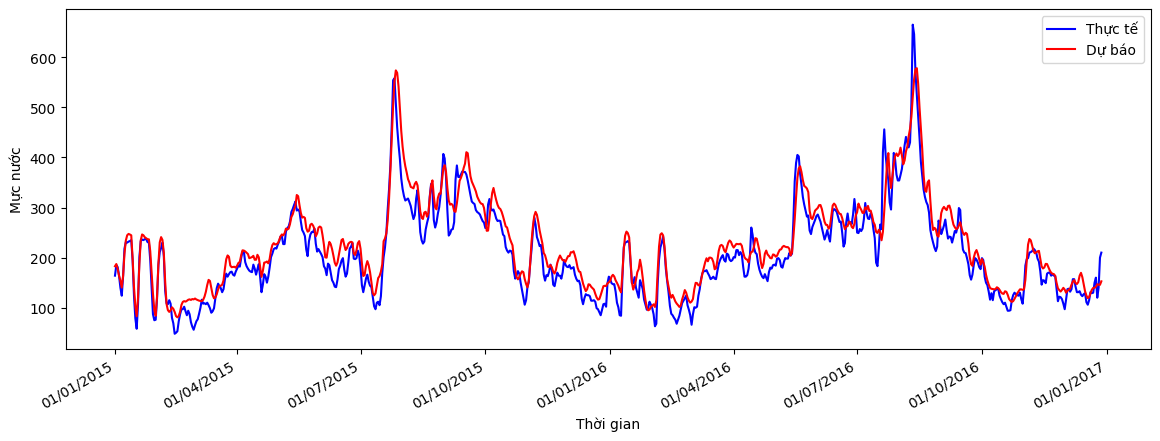

In [16]:
import matplotlib.dates as mdates

min_length = min(len(new_data.index), len(y_test_new_original), len(predictions_new_original))
print(min_length)
# Cắt ngắn mảng theo độ dài nhỏ nhất
dates = new_data.index[:min_length]

y_test_new_original = y_test_new_original[:min_length]
print(dates)
predictions_new_original = predictions_new_original[:min_length]

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_new_original, label='Thực tế', color='blue')
plt.plot(dates, predictions_new_original, label='Dự báo', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước')

# Định dạng ngày tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()